In [1]:
import pickle

data_list = range(493,499)
for data_number in data_list:
    with open('../data/both57m_rigged/%d.pkl' % data_number, 'rb') as f:
        data = pickle.load(f)
    
    full_annot = data['full_annot']
    print(data_number, full_annot,"\n")

# (267,271:70,500) (493,499:38) (832,836:310)

493 ['a person places their left hand on their waist and points their right index finger outward to indicate engaging in conversation with someone.'
 'a person puts their left hand on their waist to indicate a relaxed state.'
 'a person expresses their relaxation by placing their hands on their waist.'] 

494 ['the person crosses their arms in front of their chest to indicate refusal.'
 'a person crosses their arms in front of their chest to indicate refusal.'
 'a person crosses their arms to express resistance.'] 

495 ['a person points forward with their index finger to indicate direction to others.'
 'a person points their finger towards someone to indicate being in conversation.'
 'a person uses their finger to indicate that they are speaking.'] 

496 ['a person points at someone with their finger to indicate giving a hint to someone.'
 'a person uses their finger to indicate and point out a problem.'
 'when one person wants to give guidance to others, they use their finger to poin

In [2]:
import torch,sys,pickle
import numpy as np
sys.path.append('../utils')
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,get_idxs,np_uv

comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xml_path = '../asset/smplh_rig/scene_smplh_rig.xml'
env = MuJoCoParserClass(name='Common-Rig',rel_xml_path=xml_path,VERBOSE=False)

# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    for geom_idx in env.get_geom_idxs_from_body_name(body_name=body_name):
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
        
video = []
tick = 0

ZERO_ROOT = True

data_numbers = range(493,499)

qpos_rig_data = np.empty((0,env.model.nq))
seq_len = 0

for data_number in data_numbers:
    with open('../data/both57m_rigged/%d.pkl' % data_number, 'rb') as f:
        data = pickle.load(f)

    qpos_rig_data = np.concatenate((qpos_rig_data, data['qpos']), axis=0)
    seq_len += data['length']

start_tick = 38
end_tick = 398
final_len = end_tick - start_tick

ls2le_array = np.zeros((final_len,3))
le2lw_array = np.zeros((final_len,3))
rs2re_array = np.zeros((final_len,3))
re2rw_array = np.zeros((final_len,3))
lw_rot_array = np.zeros((final_len,3,3))
rw_rot_array = np.zeros((final_len,3,3))
lh_array = np.zeros((final_len,6))
rh_array = np.zeros((final_len,6))

while tick < end_tick-start_tick:
    q_rig = qpos_rig_data[tick+start_tick,:]
    coupled_joint_idxs_list = [[47,48],[31,32,33],[34,35,36],[42,43,44],[38,39,40],[41,37],
                                [74,75],[58,59,60],[61,62,63],[65,66,67],[69,70,71],[68,64]]

    coupled_joint_weights_list = [[1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],[2,5],
                                    [1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],[2,5]]
    
    q_couple = env.get_q_couple(
        q_raw=q_rig,
        coupled_joint_idxs_list=coupled_joint_idxs_list,
        coupled_joint_weights_list=coupled_joint_weights_list)

    if ZERO_ROOT:
        q_rig[3:7] = 0
    
    env.forward(q=q_rig,INCREASE_TICK=True)
    ls = env.get_p_body('left_shoulder')
    le = env.get_p_body('left_elbow')
    lw = env.get_p_body('left_wrist')
    rs = env.get_p_body('right_shoulder')
    re = env.get_p_body('right_elbow')
    rw = env.get_p_body('right_wrist')

    ls2le_array[tick,:] = np_uv(le-ls)
    le2lw_array[tick,:] = np_uv(lw-le)
    rs2re_array[tick,:] = np_uv(re-rs)
    re2rw_array[tick,:] = np_uv(rw-re)
    lw_rot_array[tick,:] = env.get_R_body('left_wrist')
    rw_rot_array[tick,:] = env.get_R_body('right_wrist')
    lh_array[tick,:] = q_rig[[45,47,31,34,42,38]]
    rh_array[tick,:] = q_rig[[72,74,58,61,69,65]]

    tick = tick + 1

In [3]:
SAVE_VIDEO = True
vis_tick = 0

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPLH-Rig',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

while vis_tick < final_len:
    q_rig = qpos_rig_data[vis_tick+start_tick,:]
    env.forward(q=q_rig,INCREASE_TICK=True)

    # Plot world frame
    env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
    env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label="tick:[%d/%d]"%(vis_tick,final_len))
    env.render()  
    frame = env.grab_image()
    video.append(frame)

    for rev_joint_idx,rev_joint_name in zip(env.rev_joint_idxs,env.rev_joint_names):
        axis_joint = env.model.jnt_axis[rev_joint_idx]
        p_joint,R_joint = env.get_pR_joint(joint_name=rev_joint_name)
        axis_world = R_joint@axis_joint
        axis_rgba = np.append(np.eye(3)[:,np.argmax(axis_joint)],0.2)
        axis_len,axis_r = 0.02,0.002
        env.plot_arrow_fr2to(
            p_fr=p_joint,p_to=p_joint+axis_len*axis_world,
            r=axis_r,rgba=axis_rgba)
        
    # for body_name in ['left_wrist','right_wrist']:
    #     p,R = env.get_pR_body(body_name=body_name)
    #     env.plot_T(p=p,R=R,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)

    vis_tick = vis_tick + 1
    if vis_tick == final_len:
        if not SAVE_VIDEO: vis_tick = 0

env.close_viewer()

if SAVE_VIDEO:
    import mediapy as media
    media.show_video(images=video,fps=15,width=700)

In [4]:
recon_tick = 0

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPLH-Rig',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

BODY_NAMES = ['left_elbow','left_wrist','right_elbow','right_wrist']
JOINT_NAMES = ['l_shoulder1', 'l_shoulder2', 'l_shoulder3', 'l_elbow', 'l_wrist1', 'l_wrist2', 'l_wrist3',
               'r_shoulder1', 'r_shoulder2', 'r_shoulder3', 'r_elbow', 'r_wrist1', 'r_wrist2', 'r_wrist3']

coupled_joint_idxs_list = [[47,48],[31,32,33],[34,35,36],[42,43,44],[38,39,40],[41,37],
                           [74,75],[58,59,60],[61,62,63],[65,66,67],[69,70,71],[68,64]]
coupled_joint_weights_list = [[1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],[2,5],
                              [1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],[2,5]]
hand_indices = [27,28,29,54,55,56,46,30,41,45,47,31,
                34,42,38,73,57,68,72,74,58,61,69,65]
video = []

ls = env.get_p_body('left_shoulder')
le = env.get_p_body('left_elbow')
lw = env.get_p_body('left_wrist')
rs = env.get_p_body('right_shoulder')
re = env.get_p_body('right_elbow')
rw = env.get_p_body('right_wrist')

len_ls2le = np.linalg.norm(le-ls)
len_le2lw = np.linalg.norm(lw-le)
len_rs2re = np.linalg.norm(re-rs)
len_re2rw = np.linalg.norm(rw-re)

while recon_tick < final_len:
    p_target = {}
    p_target['left_elbow'] = ls + len_ls2le * ls2le_array[recon_tick,:]
    p_target['left_wrist'] = p_target['left_elbow'] + len_le2lw * le2lw_array[recon_tick,:]
    p_target['right_elbow'] = rs + len_rs2re * rs2re_array[recon_tick,]
    p_target['right_wrist'] = p_target['right_elbow'] + len_re2rw * re2rw_array[recon_tick,:]
    
    idxs = get_idxs(env.rev_joint_names,JOINT_NAMES)
    q_mins_body,q_maxs_body = env.rev_joint_mins[idxs],env.rev_joint_maxs[idxs]
    joint_idxs_fwd_body = env.get_idxs_fwd(joint_names=JOINT_NAMES)
    joint_idxs_jac_body = env.get_idxs_jac(joint_names=JOINT_NAMES)

    q_body = env.get_qpos_joints(JOINT_NAMES)
    body_diff = 1e3
    prev_q_pos = env.data.qpos.copy()

    while body_diff > 1e-4:
        for ik_tick in range(1):
            J_list,ik_err_list = [],[]
            for ik_body_name in BODY_NAMES:
                ik_p_trgt = p_target[ik_body_name]
                ik_R_trgt = None
                IK_P = True
                IK_R = False
                J,ik_err = env.get_ik_ingredients(
                    body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                    IK_P=IK_P,IK_R=IK_R)
                J_list.append(J)
                ik_err_list.append(ik_err)
            J_stack      = np.vstack(J_list)
            ik_err_stack = np.hstack(ik_err_list)
            dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
            q_body = q_body + dq[joint_idxs_jac_body]

            q_body = np.clip(q_body,q_mins_body,q_maxs_body)
            env.forward(q=q_body,joint_idxs=joint_idxs_fwd_body)

            q_env = env.data.qpos.copy()
            body_diff = np.linalg.norm(q_env - prev_q_pos)
            prev_q_pos=q_env.copy()

    q_rig = qpos_rig_data[recon_tick,:]
    q_env[hand_indices] = q_rig[hand_indices]
    for i in range(len(coupled_joint_idxs_list)):
        coupled_joint_idx = coupled_joint_idxs_list[i]
        coupled_joint_weights = coupled_joint_weights_list[i]

        for j in range(len(coupled_joint_idx)):
            q_env[coupled_joint_idx[j]] = q_env[coupled_joint_idx[0]] * coupled_joint_weights[j] / coupled_joint_weights[0]
     
    env.forward(q=q_env,INCREASE_TICK=True)

    env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(recon_tick,final_len),axis_len=0.5,axis_width=0.005)
    env.render()

    video.append(env.grab_image())
    recon_tick += 1

env.close_viewer()
media.show_video(images=video,fps=15,width=700)

In [5]:
xml_path = '../asset/kimlab_dualarms/scene_dualarms.xml'
env = MuJoCoParserClass(name='Dual Arms',rel_xml_path=xml_path,VERBOSE=False)
env.set_geom_color(
    rgba                = (0.2,0.2,0.2,0.9),
    body_names_to_color = [
        'robot1/end_link','robot1/index_L1','robot1/index_L2','robot1/index_tip',
        'robot1/middle_L1','robot1/middle_L2','robot1/middle_tip',
        'robot1/ring_L1','robot1/ring_L2','robot1/ring_tip',
        'robot1/pinky_L1','robot1/pinky_L2','robot1/pinky_tip',
        'robot1/thumb_L1','robot1/thumb_L2','robot1/thumb_tip',
        'robot2/end_link','robot2/index_L1','robot2/index_L2','robot2/index_tip',
        'robot2/middle_L1','robot2/middle_L2','robot2/middle_tip',
        'robot2/ring_L1','robot2/ring_L2','robot2/ring_tip',
        'robot2/pinky_L1','robot2/pinky_L2','robot2/pinky_tip',
        'robot2/thumb_L1','robot2/thumb_L2','robot2/thumb_tip'],
)
print ("Done.")

Done.


In [6]:
from tqdm import tqdm

env.init_viewer(viewer_title='Dual Arms',viewer_width=800,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

BODY_NAMES = ['robot1/end_link','robot2/end_link']
JOINT_NAMES = ['robot1/joint1','robot1/joint2','robot1/joint3','robot1/joint4','robot1/joint5','robot1/joint6',
               'robot2/joint1','robot2/joint2','robot2/joint3','robot2/joint4','robot2/joint5','robot2/joint6']

ls = env.get_p_body('robot1/link2')
le = env.get_p_body('robot1/link4')
lw = env.get_p_body('robot1/link6')
rs = env.get_p_body('robot2/link2')
re = env.get_p_body('robot2/link4')
rw = env.get_p_body('robot2/link6')

len_ls2le = np.linalg.norm(le-ls)
len_le2lw = np.linalg.norm(lw-le)
len_rs2re = np.linalg.norm(re-rs)
len_re2rw = np.linalg.norm(rw-re)

q_env_array = np.zeros((final_len,env.model.nq))

for tick in tqdm(range(final_len), desc="Processing"):
    p_target = {}
    p_target['robot1/end_link'] = ls + len_ls2le * ls2le_array[tick,:] + len_le2lw * le2lw_array[tick,:]
    p_target['robot2/end_link'] = rs + len_rs2re * rs2re_array[tick,:] + len_re2rw * re2rw_array[tick,:]
    R_target = {}
    R_target['robot1/end_link'] = lw_rot_array[tick,:] @ rpy2r(np.radians([0,0,90]))
    R_target['robot2/end_link'] = rw_rot_array[tick,:] @ rpy2r(np.radians([0,0,-90]))

    idxs = get_idxs(env.rev_joint_names,JOINT_NAMES)
    q_mins_body,q_maxs_body = env.rev_joint_mins[idxs],env.rev_joint_maxs[idxs]
    joint_idxs_fwd_body = env.get_idxs_fwd(joint_names=JOINT_NAMES)
    joint_idxs_jac_body = env.get_idxs_jac(joint_names=JOINT_NAMES)

    q_body = env.get_qpos_joints(JOINT_NAMES)
    body_diff = 1e3
    prev_q_pos = env.data.qpos.copy()

    while body_diff > 1e-4:
        for ik_tick in range(1):
            J_list,ik_err_list = [],[]
            for ik_body_name in BODY_NAMES:
                ik_p_trgt = p_target[ik_body_name]
                ik_R_trgt = R_target[ik_body_name]
                IK_P = True
                IK_R = True
                J,ik_err = env.get_ik_ingredients(
                    body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                    IK_P=IK_P,IK_R=IK_R)
                J_list.append(J)
                ik_err_list.append(ik_err)
            J_stack      = np.vstack(J_list)
            ik_err_stack = np.hstack(ik_err_list)
            dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
            q_body = q_body + dq[joint_idxs_jac_body]

            q_body = np.clip(q_body,q_mins_body,q_maxs_body)
            env.forward(q=q_body,joint_idxs=joint_idxs_fwd_body)

            q_env = env.data.qpos.copy()
            body_diff = np.linalg.norm(q_env - prev_q_pos)
            prev_q_pos=q_env.copy()

    q_env_array[tick,:] = q_env
    # env.render()

env.close_viewer()

Processing: 100%|██████████| 360/360 [00:30<00:00, 11.89it/s]


In [19]:
import mediapy

env.init_viewer(viewer_title='Dual-Arm',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

SAVE_VIDEO = True

video = []
plot_tick = 0

coupled_joint_idxs_list = [
    [6,7],[8,9],[10,11],[12,13],
    [22,23],[24,25],[26,27],[28,29]
]

q_robot_array = np.zeros((final_len,env.model.nq))

while plot_tick < final_len and env.is_viewer_alive():
    p_target = {}
    p_target['robot1/end_link'] = ls + len_ls2le * ls2le_array[plot_tick,:] + len_le2lw * le2lw_array[plot_tick,:]
    p_target['robot2/end_link'] = rs + len_rs2re * rs2re_array[plot_tick,:] + len_re2rw * re2rw_array[plot_tick,:]
    R_target = {}
    R_target['robot1/end_link'] = lw_rot_array[plot_tick,:] 
    R_target['robot2/end_link'] = rw_rot_array[plot_tick,:] @ rpy2r(np.radians([0,0,-90]))

    q_robot = q_env_array[plot_tick,:]
    q_robot[[14,15,6,8,10,12]] = lh_array[plot_tick,:] * [-1,-1,1,1,1,1]
    q_robot[[30,31,22,24,26,28]] = rh_array[plot_tick,:] * [-1,-1,1,1,1,1]
    q_robot[[15,31]] += [np.pi/4, np.pi/4]

    for i in range(len(coupled_joint_idxs_list)):
        coupled_joint_idxs = coupled_joint_idxs_list[i]
        q_robot[coupled_joint_idxs[1]] = q_robot[coupled_joint_idxs[0]] * 1.05851325 + 0.72349796
    env.forward(q=q_robot,INCREASE_TICK=True)

    env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(plot_tick,final_len),axis_len=0.5,axis_width=0.005)
    env.render()
    
    # for body_name in ['robot1/end_link','robot2/end_link']:
    #     env.plot_T(p=p_target[body_name],R=R_target[body_name],PLOT_AXIS=True,axis_len=0.15,axis_width=0.005)
    #     env.plot_T(p=env.get_p_body(body_name),R=env.get_R_body(body_name),PLOT_AXIS=True,axis_len=0.2,axis_width=0.01)

    q_robot_array[plot_tick,:] = env.data.qpos.copy()
    video.append(env.grab_image())
    plot_tick += 1
    if plot_tick == final_len:
        if not SAVE_VIDEO: plot_tick = 0

env.close_viewer()
if SAVE_VIDEO:mediapy.show_video(images=video,fps=15,width=700)

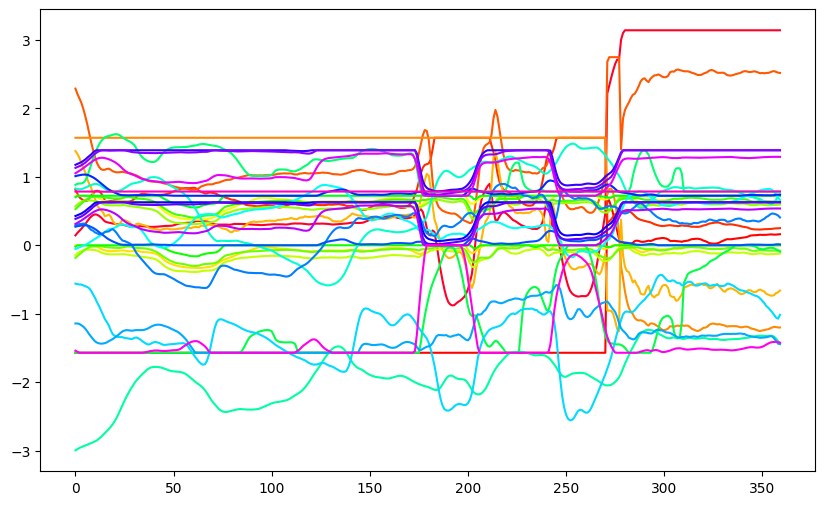

In [20]:
import matplotlib.pyplot as plt

time = np.arange(0,q_robot_array.shape[0])
plt.figure(figsize=(10,6))
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,q_robot_array.shape[1])]
for i in range(q_robot_array.shape[1]):
    plt.plot(time, q_robot_array[:,i], color=cs[i])

In [21]:
import mujoco
sys.path.append('../utils')
from mujoco_parser import init_ik_info,add_ik_info,get_dq_from_ik_info
from utility import smooth_optm_1d

joint_names_for_ik = env.rev_joint_names
collision_push_len = 0.0005
gap_per_step_cm = 0.0005
max_gap_cm = 2.0
acc_limit = 700
max_ik_tick = 100
body_name_to_exlude = "world"

L = final_len
qpos_array = q_robot_array.copy()
qpos_init_array = qpos_array.copy()

ch_step = 0
while True:
    collision_gap_cm = ch_step * gap_per_step_cm
    if collision_gap_cm > max_gap_cm:
        collision_gap_cm = max_gap_cm
    env.model.geom_gap = collision_gap_cm / 100
    env.model.geom_margin = collision_gap_cm / 100

    qpos_cf_list = []
    n_sc = 0

    for tick in range(L):
        env.forward(q=qpos_array[tick,:])
        sc_occured = False

        for ik_tick in range(max_ik_tick):
            p_contact_list,f_contact_list = [],[]
            contact_body1_list, contact_body2_list = [],[]
            
            for c_idx in range(env.data.ncon):
                contact = env.data.contact[c_idx]
                p_contact = contact.pos
                R_frame = contact.frame.reshape((3,3))

                f_contact_local = np.zeros(6,dtype=np.float64)
                mujoco.mj_contactForce(env.model,env.data,0,f_contact_local)
                f_contact = R_frame @ f_contact_local[:3]
                f_contact = np_uv(f_contact)

                contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
                contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

                if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
                    continue

                p_contact_list.append(p_contact)
                f_contact_list.append(f_contact)
                contact_body1_list.append(contact_body1)
                contact_body2_list.append(contact_body2)

            ik_info_collision = init_ik_info()
            n_contact = len(p_contact_list)

            if n_contact > 0:
                sc_occured = True
                for c_idx in range(n_contact):
                    f_contact = f_contact_list[c_idx]
                    contact_body1 = contact_body1_list[c_idx]
                    contact_body2 = contact_body2_list[c_idx]
                    p_body1 = env.get_p_body(body_name=contact_body1)
                    p_body2 = env.get_p_body(body_name=contact_body2)

                    add_ik_info(
                        ik_info = ik_info_collision,
                        body_name = contact_body1,
                        p_trgt = p_body1 - collision_push_len * np_uv(f_contact)
                    )
                    add_ik_info(
                        ik_info = ik_info_collision,
                        body_name = contact_body2,
                        p_trgt = p_body2 + collision_push_len * np_uv(f_contact)
                    )
                
                joint_idxs_jac_collision = env.get_idxs_jac(joint_names=joint_names_for_ik)
                dq,ik_err_stack = get_dq_from_ik_info(
                    env=env,
                    ik_info=ik_info_collision,
                    stepsize=1,
                    eps=1e-2,
                    th=np.radians(3.0),
                    joint_idxs_jac=joint_idxs_jac_collision,
                )

                qpos = env.data.qpos.copy()
                mujoco.mj_integratePos(env.model,qpos,dq,1)
                env.forward(q=qpos)

            else:
                break
        
        if sc_occured: n_sc = n_sc + 1
        qpos_cf_list.append(env.data.qpos.copy())

    print ("[%d] [step-1:collision handling] n_sc:[%d] collision_gap:[%.2f]cm"%(ch_step,n_sc,collision_gap_cm))

    qpos_cf_array = np.array(qpos_cf_list)
    qpos_cf_smt_array = qpos_cf_array.copy()

    for d_idx in env.get_idxs_fwd(joint_names=joint_names_for_ik):
        qpos_cf_smt_array[:,d_idx] = smooth_optm_1d(
            traj      = qpos_cf_array[:,d_idx],
            dt        = env.dt,
            acc_limit = acc_limit,
        )

    env.model.geom_gap = 0
    env.model_geom_margin = 0
    n_sc = 0

    for tick in range(L):
        q_cf_smt = qpos_cf_smt_array[tick,:]
        env.forward(q=q_cf_smt)
        sc_occured = False

        p_contact_list,f_contact_list = [],[]
        contact_body1_list,contact_body2_list = [],[]

        for c_idx in range(env.data.ncon):
            contact = env.data.contact[c_idx]
            contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
            contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

            if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
                continue

            sc_occured = True

        if sc_occured: n_sc = n_sc + 1

    qpos_array = qpos_cf_smt_array.copy()
    print ("[%d] [step-2:smooting] n_sc:[%d]"%(ch_step,n_sc))

    if n_sc == 0: break

    ch_step = ch_step + 1

q_robot_array_cf_smoothed = qpos_array

[0] [step-1:collision handling] n_sc:[57] collision_gap:[0.00]cm
[0] [step-2:smooting] n_sc:[48]
[1] [step-1:collision handling] n_sc:[48] collision_gap:[0.00]cm
[1] [step-2:smooting] n_sc:[40]
[2] [step-1:collision handling] n_sc:[40] collision_gap:[0.00]cm
[2] [step-2:smooting] n_sc:[32]
[3] [step-1:collision handling] n_sc:[32] collision_gap:[0.00]cm
[3] [step-2:smooting] n_sc:[24]
[4] [step-1:collision handling] n_sc:[24] collision_gap:[0.00]cm
[4] [step-2:smooting] n_sc:[15]
[5] [step-1:collision handling] n_sc:[15] collision_gap:[0.00]cm
[5] [step-2:smooting] n_sc:[11]
[6] [step-1:collision handling] n_sc:[11] collision_gap:[0.00]cm
[6] [step-2:smooting] n_sc:[8]
[7] [step-1:collision handling] n_sc:[8] collision_gap:[0.00]cm
[7] [step-2:smooting] n_sc:[7]
[8] [step-1:collision handling] n_sc:[7] collision_gap:[0.00]cm
[8] [step-2:smooting] n_sc:[5]
[9] [step-1:collision handling] n_sc:[5] collision_gap:[0.00]cm
[9] [step-2:smooting] n_sc:[4]
[10] [step-1:collision handling] n_sc

In [22]:
import mediapy

env.init_viewer(viewer_title='Dual-Arm',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

SAVE_VIDEO = True

video = []
plot_tick = 0
q_robot_export = np.zeros((final_len,env.model.nq))

coupled_joint_idxs_list = [
    [6,7],[8,9],[10,11],[12,13],
    [22,23],[24,25],[26,27],[28,29]
]

while plot_tick < final_len and env.is_viewer_alive():
    q_robot = q_robot_array_cf_smoothed[plot_tick,:]
    for i in range(len(coupled_joint_idxs_list)):
        coupled_joint_idxs = coupled_joint_idxs_list[i]
        q_robot[coupled_joint_idxs[1]] = q_robot[coupled_joint_idxs[0]] * 1.05851325 + 0.72349796
    env.forward(q=q_robot,INCREASE_TICK=True)

    env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(plot_tick,final_len),axis_len=0.5,axis_width=0.005)
    env.render()
    
    q_robot_export[plot_tick,:] = q_robot
    video.append(env.grab_image())
    plot_tick += 1
    if plot_tick == final_len:
        if not SAVE_VIDEO: plot_tick = 0

env.close_viewer()
if SAVE_VIDEO:mediapy.show_video(images=video,fps=15,width=700)

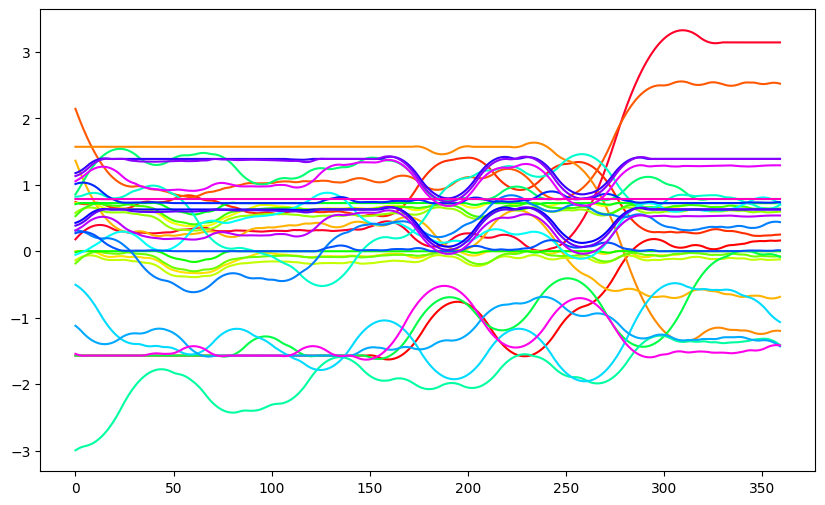

In [23]:
import matplotlib.pyplot as plt

time = np.arange(0,q_robot_export.shape[0])
plt.figure(figsize=(10,6))
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,q_robot_export.shape[1])]
for i in range(q_robot_array_cf_smoothed.shape[1]):
    plt.plot(time, q_robot_export[:,i], color=cs[i])

In [24]:
header_name = 'robot1/joint1,robot1/joint2,robot1/joint3,robot1/joint4,robot1/joint5,robot1/joint6,\
               robot1/index_q1,robot1/index_q2,robot1/middle_q1,robot1/middle_q2,robot1/ring_q1,robot1/ring_q2,robot1/pinky_q1,robot1/pinky_q2,robot1/thumb_q1,robot1/thumb_q2,\
               robot2/joint1,robot2/joint2,robot2/joint3,robot2/joint4,robot2/joint5,robot2/joint6,\
               robot2/index_q1,robot2/index_q2,robot2/middle_q1,robot2/middle_q2,robot2/ring_q1,robot2/ring_q2,robot2/pinky_q1,robot2/pinky_q2,robot2/thumb_q1,robot2/thumb_q2'

np.savetxt(
    # fname=str(data_numbers[0]) + "_" + str(data_numbers[-1]) + ".csv",
    fname="test.csv",
    X=q_robot_export[:300,:],
    delimiter=',',
    # header=header_name,
    fmt='%.6f'
    )